# Lab 5

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

Welcome to the fifth lab. We will first implement a simple scalar automatic
differentiation engine to compute partial derivatives for us,
then do a theoretical exercise about L2 regularization.

## Imports


In [1]:
import math
from abc import ABC, abstractmethod
from random import uniform
from typing import Optional, List, Union, Dict

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')

## Exercise 1

Modern deep learning frameworks compute gradients automatically,
so that you only need to define how to perform the forward pass in your code.
Under the hood, the framework constructs a computational graph based on the operations
you used. For example, consider the node:

$$
4xy+e^{-y}
$$

It can be translated into a graph that looks like this:

![](../utils/05-lab-graph1.png)

Where we have 'leaf' nodes at the top for variables and constants, and 'internal' nodes
for operations. To make things simpler, in this exercise we will only work with
scalar operations and scalar variables, but what we are going to create could, in
principle, be extended to work with vectors and matrices. Section 6 of chapter 5 of the
_Mathematics for Machine Learning_ book (https://mml-book.github.io/) is a good
supplementary read.

The naming of the classes responds to:

 - `Sum` for Addition $x+y$
 - `Sub` for Subtraction $x-y$
 - `Mul` for Product $x\cdot y$
 - `Div` for Division $x / y$
 - `Exp` for Exponentiation $e^x$
 - `TanH` for Hyperbolic tangent $\tanh(x)$
 - `Log` for Logarithm $\log(x)$


We first define some utilities to easily create nodes.
An abstract class gives us a common interface across all the respective nodes that
we will derive from it. This doesn't make sense now, as the class is basically empty,
but we will extend the definition over the course of the exercise.

In [2]:
class BaseNode(ABC):
    pass


class Const(BaseNode):
    def __init__(self, value: Union[float, int]):
        self.value = value


class Var(BaseNode):
    def __init__(self, name: str):
        self.name = name


class BinaryOperation(BaseNode, ABC):
    def __init__(self, x: BaseNode, y: BaseNode):
        self.x = x
        self.y = y


class Sum(BinaryOperation):
    pass


class Sub(BinaryOperation):
    pass


class Mul(BinaryOperation):
    pass


class Div(BinaryOperation):
    pass


class Function(BaseNode, ABC):
    def __init__(self, x: BaseNode):
        self.x = x


class Exp(Function):
    pass


class Log(Function):
    pass


class TanH(Function):
    pass

In [3]:
# We then define the graph from the equation before.
x = Var('x')
y = Var('y')

z = Sum(
    x=Mul(
        x=Mul(
            x=Const(4),
            y=x
        ),
        y=y,
    ),
    y=Exp(
        x=Mul(
            x=Const(-1),
            y=y
    ))
)

print(z)
print(z.x.x)
print(z.y)

This structure of nested objects contains the computational graph for the node above.
Now, we can write code to manipulate this expression as we please.
In the course of this exercise, we will see how:

 1. Print an expression,
 2. Compute its value, given the values of the variables involved,
 3. Differentiate it to automatically find partial derivatives with respect to any given variable,
 4. Transform it into simpler expressions that are cheaper to handle, and
 5. Write code to train a neural network without getting our hands dirty with derivatives ever again.


### Printing an expression
First, since it is quite hard to understand the node from the representation above,
let us extend the classes to convert a computational graph into a string representation
that is easier to understand. For example, the expression $x+2y$ should be converted to

In [4]:
['(', 'x', '+', '(', '2', '*', 'y', ')', ')']

['(', 'x', '+', '(', '2', '*', 'y', ')', ')']

Which can be printed easily using `" ".join(<list>)`, resulting in `( x + ( 2 * y ) )`.

Such a function should be _recursive_. This means that when simplifying a complicated
expression it will call itself on each constituting piece of that expression, and
"assemble" the results together.
Conceptually, the procedure is similar to the factorial operation,
which is recursively defined in terms of the factorial of a smaller number:

\begin{equation}
n!=\begin{cases}
1 & \text{if }n < 1 \\
n\cdot(n-1)! & \text{otherwise}
\end{cases}
\end{equation}

This definition can be converted into Python as:

In [5]:
def factorial(n: int) -> int:
    if n < 1:
        return 1
    else:
        return n * factorial(n - 1)

print(factorial(4))

24


In a similar way, we extend the classes with `__str__`, which is a Python utility to
obtain a custom string representation of an object. If we define it correctly, we
are able to traverse through the tree and print the expression.

In [6]:

class BaseNode(ABC):
    @abstractmethod
    def __str__(self) -> str:
        pass


class Const(BaseNode):
    def __init__(self, value: Union[float, int]):
        self.value = value

    def __str__(self) -> str:
        return str(self.value)


class Var(BaseNode):
    def __init__(self, name: str):
        self.name = name

    def __str__(self) -> str:
        return self.name


class BinaryOperation(BaseNode, ABC):
    def __init__(self, x: BaseNode, y: BaseNode):
        self.x = x
        self.y = y


class Sum(BinaryOperation):
    def __str__(self) -> str:
        return "({} + {})".format(self.x, self.y)


class Sub(BinaryOperation):
    def __str__(self) -> str:
        return "({} - {})".format(self.x, self.y)


class Mul(BinaryOperation):
    def __str__(self) -> str:
        return "({} * {})".format(self.x, self.y)


class Div(BinaryOperation):
    def __str__(self) -> str:
        return "({} / {})".format(self.x, self.y)


class Function(BaseNode, ABC):
    def __init__(self, x: BaseNode):
        self.x = x


class Exp(Function):
    def __str__(self) -> str:
        return "exp({})".format(self.x)


class Log(Function):
    def __str__(self) -> str:
        return "log({})".format(self.x)


class TanH(Function):
    def __str__(self) -> str:
        return "tanh({})".format(self.x)

In [7]:
x = Var('x')
y = Var('y')

z = Sum(
    x=Mul(
        x=Mul(
            x=Const(4),
            y=x
        ),
        y=y,
    ),
    y=Exp(
        x=Mul(
            x=Const(-1),
            y=y
    ))
)

print(z)

(((4 * x) * y) + exp((-1 * y)))


This is much simpler to read!

### Computing the value of an expression
We can now extend the classes to compute the value of an expression given values for
the variables. The methods should be recursive too.

In [8]:

class BaseNode(ABC):
    @abstractmethod
    def __str__(self) -> str:
        pass

    @abstractmethod
    def eval(self) -> Union[float, int]:
        pass


class Const(BaseNode):
    def __init__(self, value: Union[float, int]):
        self.value = value

    def __str__(self) -> str:
        return str(self.value)

    def eval(self) -> Union[float, int]:
        return self.value


class Var(BaseNode):
    def __init__(self, name: str, value: Optional[Union[float, int]] = None):
        self.name = name
        self.value = value
        
    def set_value(self, value: Union[float, int]) -> None:
        self.value = value

    def __str__(self) -> str:
        return self.name
    
    def eval(self) -> Union[float, int]:
        if self.value is None:
            raise ValueError('Value is not set. Evaluation is not possible.')
        return self.value


class BinaryOperation(BaseNode, ABC):
    def __init__(self, x: BaseNode, y: BaseNode):
        self.x = x
        self.y = y


class Sum(BinaryOperation):
    def __str__(self) -> str:
        return '({} + {})'.format(self.x, self.y)
    
    def eval(self) -> Union[float, int]:
        return self.x.eval() + self.y.eval()

class Sub(BinaryOperation):
    def __str__(self) -> str:
        return '({} - {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() - self.y.eval()


class Mul(BinaryOperation):
    def __str__(self) -> str:
        return '({} * {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() * self.y.eval()


class Div(BinaryOperation):
    def __str__(self) -> str:
        return '({} / {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() / self.y.eval()


class Function(BaseNode, ABC):
    def __init__(self, x: BaseNode):
        self.x = x


class Exp(Function):
    def __str__(self) -> str:
        return 'exp({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.exp(self.x.eval())


class Log(Function):
    def __str__(self) -> str:
        return 'log({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.log(self.x.eval())

class TanH(Function):
    def __str__(self) -> str:
        return 'tanh({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.tanh(self.x.eval())

In [9]:
x = Var('x', value=2)
y = Var('y', value=3)

z = Sum(
    x=Mul(
        x=Mul(
            x=Const(4),
            y=x
        ),
        y=y,
    ),
    y=Exp(
        x=Mul(
            x=Const(-1),
            y=y
    ))
)

print(round(z.eval(), 4))

24.0498


The result that we expect is, of course:

In [10]:
print(round(4 * 2 * 3 + math.exp(-3), 4))

24.0498


### Differentiating an expression

We can finally see how to differentiate an expression with respect to a variable.
We do this again through extending the classes to differentiates each argument
and merge the result. Note that this should return a new computational
graph that contains the operations necessary to compute the partial derivative
we are interested in.
Each `differentiate` method gets the argument `var` that specifies the name of the
variable of which we are computing the gradient.

Remember to use the chain rule where appropriate!

In [11]:

class BaseNode(ABC):
    @abstractmethod
    def __str__(self) -> str:
        pass

    @abstractmethod
    def eval(self) -> Union[float, int]:
        pass

    @abstractmethod
    def differentiate(self, var: str) -> BaseNode:
        pass


class Const(BaseNode):
    def __init__(self, value: Union[float, int]):
        self.value = value

    def __str__(self) -> str:
        return str(self.value)

    def eval(self) -> Union[float, int]:
        return self.value

    def differentiate(self, var: str) -> BaseNode:
        return Const(0)


class Var(BaseNode):
    def __init__(self, name: str, value: Optional[Union[float, int]] = None):
        self.name = name
        self.value = value

    def set_value(self, value: Union[float, int]) -> None:
        self.value = value

    def __str__(self) -> str:
        return self.name

    def eval(self) -> Union[float, int]:
        if self.value is None:
            raise ValueError('Value is not set. Evaluation is not possible.')
        return self.value

    def differentiate(self, var: str) -> BaseNode:
        return Const(1) if self.name == var else Const(0)


class BinaryOperation(BaseNode, ABC):
    def __init__(self, x: BaseNode, y: BaseNode):
        self.x = x
        self.y = y


class Sum(BinaryOperation):
    def __str__(self) -> str:
        return '({} + {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() + self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sum(self.x.differentiate(var), self.y.differentiate(var))


class Sub(BinaryOperation):
    def __str__(self) -> str:
        return '({} - {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() - self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sub(self.x.differentiate(var), self.y.differentiate(var))


class Mul(BinaryOperation):
    def __str__(self) -> str:
        return '({} * {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() * self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sum(x=Mul(self.x.differentiate(var), self.y), y=Mul(self.x, self.y.differentiate(var)))


class Div(BinaryOperation):
    def __str__(self) -> str:
        return '({} / {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() / self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Div(x=Sub(x=Mul(self.x.differentiate(var), self.y), y=Mul(self.y.differentiate(var), self.x)), y=Mul(self.y, self.y))


class Function(BaseNode, ABC):
    def __init__(self, x: BaseNode):
        self.x = x


class Exp(Function):
    def __str__(self) -> str:
        return 'exp({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.exp(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Mul(x=Exp(self.x), y=self.x.differentiate(var))


class Log(Function):
    def __str__(self) -> str:
        return 'log({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.log(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Div(x=self.x.differentiate(var), y=self.x)

class TanH(Function):
    def __str__(self) -> str:
        return 'tanh({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.tanh(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Mul(x=Sub(x=Const(1), y=Mul(TanH(self.x), TanH(self.x))), y=self.x.differentiate(var))


In [12]:
x = Var('x', value=2)
y = Var('y', value=3)

z = Sum(
    x=Mul(
        x=Mul(
            x=Const(4),
            y=x
        ),
        y=y,
    ),
    y=Exp(
        x=Mul(
            x=Const(-1),
            y=y
    ))
)

dz = z.differentiate('x')
print(dz)

(((((0 * x) + (4 * 1)) * y) + ((4 * x) * 0)) + (exp((-1 * y)) * ((0 * y) + (-1 * 0))))


This looks a bit complicated, but by applying some trivial simplifications we see it is correct:

\begin{align*}
& ( ( ( ( ( 0 \cdot x ) + ( 4 \cdot 1 ) ) \cdot y ) + ( ( 4 \cdot x ) \cdot 0 ) ) + ( exp ( ( -1 \cdot y ) ) \cdot ( ( 0 \cdot y ) + ( -1 \cdot 0 ) ) ) )  \\
&\qquad= ( ( ( 0 + 4 ) \cdot y ) + 0 ) + ( exp ( ( -1 \cdot y ) ) \cdot ( 0 + 0 ) ) ) \\
&\qquad= ( 4 \cdot y ) + ( exp ( ( -1 \cdot y ) ) \cdot 0 ) ) \\
&\qquad= ( 4 \cdot y ) + 0 \\
&\qquad= 4 \cdot y \\
&\qquad= \frac{\text{d}}{\text{d}x} \left(4xy+e^{-y}\right)
\end{align*}

These simplification rules are trivial arithmetic identities:

 - $0+x=x$
 - $0\cdot x=0$
 - $1\cdot x=x$
 - $0/x=0$

Let us extend the classes that use these identities to automatically simplify `dz` in
the same way we just did. As with differentiation, this should return a
new computational graph.

In [13]:

class BaseNode(ABC):
    @abstractmethod
    def __str__(self) -> str:
        pass

    @abstractmethod
    def eval(self) -> Union[float, int]:
        pass

    @abstractmethod
    def differentiate(self, var: str) -> BaseNode:
        pass

    @abstractmethod
    def simplify(self):
        pass


class Const(BaseNode):
    def __init__(self, value: Union[float, int]):
        self.value = value

    def __str__(self) -> str:
        return str(self.value)

    def eval(self) -> Union[float, int]:
        return self.value

    def differentiate(self, var: str) -> BaseNode:
        return Const(0)

    def simplify(self):
        return self


class Var(BaseNode):
    def __init__(self, name: str, value: Optional[Union[float, int]] = None):
        self.name = name
        self.value = value

    def set_value(self, value: Union[float, int]) -> None:
        self.value = value

    def __str__(self) -> str:
        return self.name

    def eval(self) -> Union[float, int]:
        if self.value is None:
            raise ValueError('Value is not set. Evaluation is not possible.')
        return self.value

    def differentiate(self, var: str) -> BaseNode:
        return Const(1) if self.name == var else Const(0)

    def simplify(self):
        return self


class BinaryOperation(BaseNode, ABC):
    def __init__(self, x: BaseNode, y: BaseNode):
        self.x = x
        self.y = y


class Sum(BinaryOperation):
    def __str__(self) -> str:
        return '({} + {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() + self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sum(self.x.differentiate(var), self.y.differentiate(var))

    def simplify(self):
        simple_x = self.x.simplify()
        simple_y = self.y.simplify()

        if isinstance(simple_x, Const):
            if simple_x.value == 0:
                # Rule: 0 + y = y
                return simple_y

        if isinstance(simple_y, Const):
            if simple_y.value == 0:
                # Rule: x + 0 = x
                return simple_x

        if isinstance(simple_x, Const) and isinstance(simple_y, Const):
            # If both arguments are constants we can perform the sum immediately
            return Const(simple_x.value + simple_y.value)

        # Cannot simplify further. Return a new sum node with the simplified operands.
        return Sum(simple_x, simple_y)


class Sub(BinaryOperation):
    def __str__(self) -> str:
        return '({} - {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() - self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sub(self.x.differentiate(var), self.y.differentiate(var))

    def simplify(self):
        simple_x = self.x.simplify()
        simple_y = self.y.simplify()

        if isinstance(simple_x, Const):
            if simple_x.value == 0:
                # Rule: 0 - y = -y
                return Mul(x=Const(-1), y=simple_y)

        if isinstance(simple_y, Const):
            if simple_y.value == 0:
                # Rule: x - 0 = x
                return simple_x

        if isinstance(simple_x, Const) and isinstance(simple_y, Const):
            # If both arguments are constants we can perform the sum immediately
            return Const(simple_x.value - simple_y.value)

        # Cannot simplify further. Return a new sum node with the simplified operands.
        return Sub(simple_x, simple_y)

class Mul(BinaryOperation):
    def __str__(self) -> str:
        return '({} * {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() * self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Sum(
            x=Mul(self.x.differentiate(var), self.y),
            y=Mul(self.x, self.y.differentiate(var))
        )

    def simplify(self):
        simple_x = self.x.simplify()
        simple_y = self.y.simplify()

        if isinstance(simple_x, Const):
            if simple_x.value == 0:
                # Rule: 0 * y = 0
                return Const(0)
            if simple_x.value == 1:
                # Rule 1 * y = y
                return simple_y

        if isinstance(simple_y, Const):
            if simple_y.value == 0:
                # Rule: x * 0 = 0
                return Const(0)
            if simple_y.value == 1:
                return simple_x

        if isinstance(simple_x, Const) and isinstance(simple_y, Const):
            # If both arguments are constants we can perform the sum immediately
            return Const(simple_x.value * simple_y.value)

        # Cannot simplify further. Return a new sum node with the simplified operands.
        return Mul(simple_x, simple_y)

class Div(BinaryOperation):
    def __str__(self) -> str:
        return '({} / {})'.format(self.x, self.y)

    def eval(self) -> Union[float, int]:
        return self.x.eval() / self.y.eval()

    def differentiate(self, var: str) -> BaseNode:
        return Div(
            x=Sub(
                x=Mul(self.x.differentiate(var), self.y),
                y=Mul(self.y.differentiate(var), self.x)
            ),
            y=Mul(self.y, self.y)
        )

    def simplify(self):
        simple_x = self.x.simplify()
        simple_y = self.y.simplify()

        if isinstance(simple_x, Const):
            if simple_x.value == 0:
                # Rule: 0 / y = 0
                return Const(0)

        if isinstance(simple_y, Const):
            if simple_y.value == 0:
                # Rule: x / 0 = error
                raise ZeroDivisionError("division by zero")            
            if simple_y.value == 1:
                return simple_x

        if isinstance(simple_x, Const) and isinstance(simple_y, Const):
            # If both arguments are constants we can perform the sum immediately
            return Const(simple_x.value / simple_y.value)

        # Cannot simplify further. Return a new sum node with the simplified operands.
        return Div(simple_x, simple_y)

class Function(BaseNode, ABC):
    def __init__(self, x: BaseNode):
        self.x = x


class Exp(Function):
    def __str__(self) -> str:
        return 'exp({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.exp(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Mul(
            x=Exp(self.x),
            y=self.x.differentiate(var)
        )

    def simplify(self):
        simple_x = self.x.simplify()
        
        if isinstance(simple_x, Const):
            # exp(0) = 1
            if simple_x.value == 0:
                return Const(1)
            else:
                return Const(math.exp(simple_x.value))
        
        return Exp(simple_x)

class Log(Function):
    def __str__(self) -> str:
        return 'log({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.log(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Div(
            x=self.x.differentiate(var),
            y=self.x
        )

    def simplify(self):
        simple_x = self.x.simplify()

        if isinstance(simple_x, Const):
            if simple_x.value == 1:
                return Const(0)
            elif simple_x.value > 0:
                return Const(math.log(simple_x.value))

        if isinstance(simple_x, Exp):
            return simple_x.x.simplify()
        
        return Log(simple_x)

class TanH(Function):
    def __str__(self) -> str:
        return 'tanh({})'.format(self.x)

    def eval(self) -> Union[float, int]:
        return math.tanh(self.x.eval())

    def differentiate(self, var: str) -> BaseNode:
        return Mul(
            x=Sub(
                x=Const(1),
                y=Mul(TanH(self.x), TanH(self.x))
            ),
            y=self.x.differentiate(var)
        )

    def simplify(self):
        simple_x = self.x.simplify()
        
        if isinstance(simple_x, Const):
            if simple_x.value == 0:
                return Const(0)
            else:
                return Const(math.tanh(simple_x.value))

        return TanH(simple_x)

In [14]:
x = Var('x', value=2)
y = Var('y', value=3)

z = Sum(
    x=Mul(
        x=Mul(
            x=Const(4),
            y=x
        ),
        y=y,
    ),
    y=Exp(
        x=Mul(
            x=Const(-1),
            y=y
    ))
)

dz = z.differentiate('x')
print(dz.simplify())

(4 * y)


The result matches what we showed above, $4y$. Simplifying the graph with these and
other, more advanced tricks, can greatly speed up code.

Now we are also equipped to perform differentiation of any order,
for example $\partial z / \partial x\partial y$ is simply:

In [15]:

print(z.differentiate('x').differentiate('y'))
print(z.differentiate('x').differentiate('y').simplify())
print(z.differentiate('x').differentiate('y').eval())

(((((((0 * x) + (0 * 0)) + ((0 * 1) + (4 * 0))) * y) + (((0 * x) + (4 * 1)) * 1)) + ((((0 * x) + (4 * 0)) * 0) + ((4 * x) * 0))) + (((exp((-1 * y)) * ((0 * y) + (-1 * 1))) * ((0 * y) + (-1 * 0))) + (exp((-1 * y)) * (((0 * y) + (0 * 1)) + ((0 * 0) + (-1 * 0))))))
4
4.0


### Training a network

Let us now define a computational graph that performs the forward pass of a
simple network, and use the functions above to compute the gradients of the parameters.
We will use the same network we used in the third lab, reproduced below, and, as usual,
we will test the code on the five points dataset. Since the functions we have written
so far only work with scalar values, we will perform stochastic gradient descent
using one sample at a time.

![](../utils/03-lab-nn.png)

In [16]:

# The two input nodes
x1 = Var('x1')
x2 = Var('x2')

# Parameters for the first hidden neuron
b1 = Var('b1')
w11 = Var('w11')
w21 = Var('w21')

# Compute the output of the first hidden neuron
z1in = Sum(
    x=b1,
    y=Sum(
       x=Mul(x1, w11),
       y=Mul(x2, w21)
    )
)

z1out = TanH(z1in)

print(z1out)

tanh((b1 + ((x1 * w11) + (x2 * w21))))


Now, complete the remaining part of the network:

In [17]:

b2 = Var('b2')
w12 = Var('w12')
w22 = Var('w22')

z2in = Sum(
    x=b2,
    y=Sum(
        x=Mul(x1, w12),
        y=Mul(x2, w22)
    )
)

z2out = TanH(z2in)

print(z2out)

c = Var('c')
u1 = Var('u1')
u2 = Var('u2')

fin = Sum(
    x=c,
    y=Sum(
        x=Mul(z1out, u1),
        y=Mul(z2out, u2)
    )
)

print(fin)

fout = Div(x=Exp(fin), y=Sum(x=Const(1), y=Exp(fin)))

print(fout)

tanh((b2 + ((x1 * w12) + (x2 * w22))))
(c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2)))
(exp((c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2)))) / (1 + exp((c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2))))))


And this defines the forward pass.

We can now compute the predictions of the network by evaluating `fout`,
providing values for the inputs and weights. For example:

In [18]:

# Values for weights and biases
b1.set_value(1.543385)
w11.set_value(3.111573)
w12.set_value(-2.808800)

b2.set_value(1.373085)
w21.set_value(3.130452)
w22.set_value(-2.813466)

c.set_value(-4.241453)
u1.set_value(4.036489)
u2.set_value(4.074885)

# Values for the input
x1.set_value(1)
x2.set_value(-1)

fout.eval()

0.9533527373765618

Which should be about 0.9.
We now have to compute the cross-entropy loss.
For numerical stability, we will compute the loss using $f_{in}$ instead of $f_{out}$.
Therefore, first, show that:

\begin{equation}
-y\cdot\log(f_{out})-(1-y)\cdot\log(1-f_{out})=
f_{in}-f_{in}\cdot y+\log(1+e^{-f_{in}})
\end{equation}


In [19]:

# This variable contains the label for the sample the network is predicting
y = Var('y')

loss = Sum(
    x=Sub(
        x=fin, 
        y=Mul(
            x=fin, 
            y=y
            )
        ),
    y=Log(
        x=Sum(
            x=Const(1),
            y=Exp(
                x=Mul(
                    x=Const(-1),
                    y=fin
                )
            )
        )
    )
)

print(loss)

(((c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2))) - ((c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2))) * y)) + log((1 + exp((-1 * (c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2))))))))


This is starting to look complicated!
Luckily, this time, we do not have to get our hands dirty with derivatives.
Let us find the graphs for the derivatives of each parameter of the network.

In [20]:

def get_gradient_graphs(graph: BaseNode, param_nodes: List[Var]) -> Dict:
    graph_dict: Dict = {}
    for param_node in param_nodes:
        graph_dict.update({
            param_node.name : graph.differentiate(param_node.name)
        })
    return graph_dict

parameter_nodes = [b1, w11, w12, b2, w21, w22, c, u1, u2]
gradient_graphs = get_gradient_graphs(loss, parameter_nodes)
print(gradient_graphs.get('w11'))

(((0 + (((((1 - (tanh((b1 + ((x1 * w11) + (x2 * w21)))) * tanh((b1 + ((x1 * w11) + (x2 * w21)))))) * (0 + (((0 * w11) + (x1 * 1)) + ((0 * w21) + (x2 * 0))))) * u1) + (tanh((b1 + ((x1 * w11) + (x2 * w21)))) * 0)) + ((((1 - (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * tanh((b2 + ((x1 * w12) + (x2 * w22)))))) * (0 + (((0 * w12) + (x1 * 0)) + ((0 * w22) + (x2 * 0))))) * u2) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * 0)))) - (((0 + (((((1 - (tanh((b1 + ((x1 * w11) + (x2 * w21)))) * tanh((b1 + ((x1 * w11) + (x2 * w21)))))) * (0 + (((0 * w11) + (x1 * 1)) + ((0 * w21) + (x2 * 0))))) * u1) + (tanh((b1 + ((x1 * w11) + (x2 * w21)))) * 0)) + ((((1 - (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * tanh((b2 + ((x1 * w12) + (x2 * w22)))))) * (0 + (((0 * w12) + (x1 * 0)) + ((0 * w22) + (x2 * 0))))) * u2) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * 0)))) * y) + ((c + ((tanh((b1 + ((x1 * w11) + (x2 * w21)))) * u1) + (tanh((b2 + ((x1 * w12) + (x2 * w22)))) * u2))) * 0))) + ((0 + (exp((-1 * (c + ((tanh((b1 + ((x1

As you can see, there is a great deal of repetition in this expression.
The repetitions could be removed by storing, in each node, its current value and
gradient, so that we would not need to re-compute them every time. Modern deep
learning frameworks indeed do this, and are able to compute the gradient of the
loss with respect to all parameters in a single pass, but here we accept these
inefficiencies for the sake of simplicity.

We are now ready to train this network:

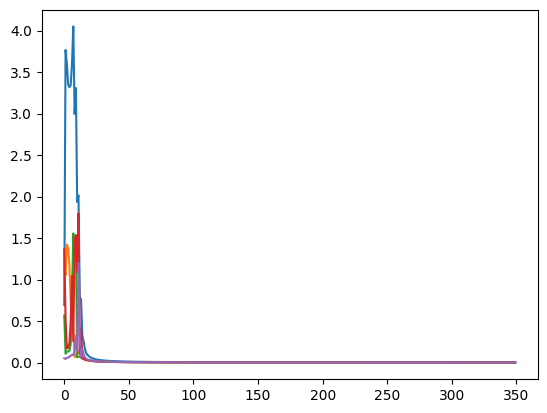

In [25]:

# Create dataset.
x = [
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
]
labels = [1, 0, 0, 0, 0]

# Glorot initialization for the parameters.
def init_params(param_nodes: List[Var], bias_names: List[str]) -> None:
    b = math.sqrt(6 / 4)
    for param_node in param_nodes:
        if param_node.name in bias_names:
            param_node.set_value(0.0)
        else:
            param_node.set_value(uniform(-b, b))

init_params(parameter_nodes, ['b1', 'b2', 'c'])

# Training Loop.
# Losses dict follows (index of sample : list of losses during training).
loss_dict = {i: [] for i in range(len(x))}
learning_rate = 2.5
for ep in range(350):
    ep_loss = 0.
    for i in range(len(x)):
        # Set the correct values for the inputs and label.
        x1.set_value(x[i][0])
        x2.set_value(x[i][1])
        y.set_value(labels[i])

        current_loss = loss.eval()
        loss_dict[i].append(current_loss)
        ep_loss += loss_dict[i][-1]

        gradient_graphs = get_gradient_graphs(loss, parameter_nodes)

        for param_node in parameter_nodes:
            gradient_value = gradient_graphs[param_node.name].eval()
            param_node.set_value(param_node.eval() - learning_rate * gradient_value)

    if ep > 100:
        learning_rate = 1.0
    if ep > 200:
        learning_rate = 0.1

    print('EPOCH: \t {:5} \t LOSS: \t {:.5f}'.format(ep + 1, float(ep_loss)), end='\r')


# Plot loss development.
for sample_loss in loss_dict.values():
    plt.plot(sample_loss)
plt.show()

You can clearly see how the loss of each individual training sample evolves over time.
This also explains the "saddle" you might have noticed in the loss curve from the
previous lab.

And these are the predictions for the five points:

In [26]:

for i in range(len(x)):
    x1.set_value(x[i][0])
    x2.set_value(x[i][1])
    y.set_value(labels[i])

    prediction = fout.eval()
    print('SAMPLE:\t{}\tTRUE:\t{}\tPRED:\t{:.3f}'.format(i, labels[i], prediction))

SAMPLE:	0	TRUE:	1	PRED:	0.997
SAMPLE:	1	TRUE:	0	PRED:	0.001
SAMPLE:	2	TRUE:	0	PRED:	0.002
SAMPLE:	3	TRUE:	0	PRED:	0.001
SAMPLE:	4	TRUE:	0	PRED:	0.002


### Conclusion
What we did in this exercise is (a simplification of) how deep learning frameworks
evaluate the code you write. You only need to define how to compute the output of
the network, and the framework figures out the necessary gradients on its own.
They provide a much better user interface, allowing you to use `+`, `-`, `/`, `*` etc.
as you normally would instead of the clumsy node constructors we defined here,
but there is always a computational graph hidden behind the curtains.



## Exercise 2

This exercise should improve your understanding of weight decay (or L2 regularization).

  1. Consider a quadratic error function $E(\textbf{w})=E_0+\textbf{b}^T\textbf{w}+1/2\cdot\textbf{w}^T\textbf{H}\textbf{w}$ and its regularized counterpart $E'(\textbf{w})=E(\textbf{w})+\tau/2 \cdot\textbf{w}^T\textbf{w}$, and let $\textbf{w}^*$ and $\tilde{\textbf{w}}$ be the minimizers of $E$ and $E'$ respectively. We want to find a node to express $\tilde{\textbf{w}}$ as a function of $\textbf{w}^*$, i.e. find the displacement introduced by weight decay.

      - Find the gradients of $E$ and $E'$. Note that, at the global minimum,
     we have $\nabla E(\textbf{w}^*)=\nabla E'(\tilde{\textbf{w}})=0$.
      - In the equality above, express $\textbf{w}^*$ and $\tilde{\textbf{w}}$ as a
     linear combination of the eigenvectors of $\textbf{H}$.
      - Through algebraic manipulation, obtain $\tilde{\textbf{w}}_i$ as a function
     of $\textbf{w}^*_i$.
      - Interpret this result geometrically.
      - Note: $\textbf{H}$ is square, symmetric, and positive definite,
     which means that its eigenvectors are pairwise orthogonal and its eigenvalues
     are positive (spectral theorem).

  2. Consider a linear network of the form $y=\textbf{w}^T\textbf{x}$ and the mean
squared error as a loss function. Assume that every observation is corrupted
with Gaussian noise $\epsilon\sim\mathcal{N}(\textbf{0}, \sigma^2\textbf{I})$.
Compute the expectation of the gradient under $\epsilon$ and,
show that adding gaussian noise to the inputs has the same effect of weight decay.
